# Figures Using Bar Sizes

## Requirements

This notebook is meant to be run within the full **s4g_barfractions** repository, including the associated Python modules and data files.

In addition, this notebook requires, directly or indirectly, the following Python packages:
   * numpy
   * matplotlib
   * Michaele Cappellari's Python package [cap_loess_1d](http://www-astro.physics.ox.ac.uk/~mxc/software/#loess)
   
By default, output PDF figure files are *not* saved to disk; to enable this, set the `savePlots` variable in the **Setup** cell to `True` and change the `plotDir` variable (same cell) to point to where you want the figures saved.

## Setup

In [1]:
import numpy as np
import cap_loess_1d

import datautils as du
import plotutils as pu
import s4gutils

# paths for locating data, saving plots, etc.
dataDir = "./data/"
simDir = dataDir
# change the following if you want to save the figures somewhere convenient
baseDir = "/Users/erwin/Documents/Working/Paper-s4gbars/"
plotDir = baseDir + "plots/"
savePlots = False

s4gdata = du.ReadCompositeTable(dataDir+"s4gbars_table.dat", columnRow=25, dataFrame=True)
nDisksTotal = len(s4gdata.name)

fwhm_s4g1 = 1.66   # 3.6-micron FWHM in arcsec
fwhm_s4g2 = 2.0   # approx. S4G FWHM in arcsec acc. to Salo+2015
fwhm_kpc_s4g1 = pc(16.8) * fwhm_s4g1 / 1e3
fwhm_kpc_s4g2 = pc(16.8) * fwhm_s4g2 / 1e3
fwhm_kpc_gz2 = 1.25  # z = 0.01--0.06, mean z = 0.045, FWHM = 1.4 arcsec


# axis labels, etc., for plots
xtmstar = r"$\log \: (M_{\star} / M_{\odot})$"
xtfgas = r"$\log \: (M_{\rm HI} / M_{\star})$"
xtgmr = r"$g - r$"
ytfbar = r"Bar Fraction $f_{\rm bar}$"
ytbarsize_kpc = r"Bar size $a_{\rm vis}$ [kpc]"
ytbarsize_kpc_obs = r"Observed bar size $a_{\rm vis}$ [kpc]"

s4g_fwhm_txt = r"S$^{4}$G $\langle$FWHM$\rangle$"

In [2]:
%pylab inline

matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.labelsize'] = 20

Populating the interactive namespace from numpy and matplotlib


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Defining different subsamples via index vectors

Lists of integers defining indices of galaxies in Parent Disc Sample which meet various criteria
that define specific subsamples.

In [3]:
# general subsamples: all barred, all unbarred, all spirals
ii_barred = [i for i in range(nDisksTotal) if s4gdata.sma[i] > 0]
ii_unbarred = [i for i in range(nDisksTotal) if s4gdata.sma[i] <= 0]
ii_spirals = [i for i in range(nDisksTotal) if s4gdata.t_s4g[i] > -0.5]


# Sample 1: spirals with D < 25 Mpc -- 663 spirals: 373 barred, 290 unbarred
ii_all_limited1 = [i for i in ii_spirals if s4gdata.dist[i] <= 25]
ii_barred_limited1 = [i for i in ii_all_limited1 if i in ii_barred]
ii_unbarred_limited1 = [i for i in ii_all_limited1 if i not in ii_barred]

ii_barred_m9 = [i for i in ii_barred if s4gdata.logmstar[i] >= 9]


# Sample 1m: spirals with D < 25 Mpc and log Mstar >= 8.5 -- 576 spirals: 356 barred, 220 unbarred
ii_all_limited1_m8_5 = [i for i in ii_all_limited1 if s4gdata.logmstar[i] >= 8.5]
ii_barred_limited1_m8_5 = [i for i in ii_all_limited1_m8_5 if i in ii_barred]
ii_unbarred_limited1_m8_5 = [i for i in ii_all_limited1_m8_5 if i not in ii_barred]

# limited subsample 2: D < 30 Mpc -- 856 galaxies: 483 barred, 373 unbarred
ii_all_limited2 = [i for i in ii_spirals if s4gdata.dist[i] <= 30]
ii_barred_limited2 = [i for i in ii_all_limited2 if i in ii_barred]
ii_unbarred_limited2 = [i for i in ii_all_limited2 if i not in ii_barred]

# limited subsample 2m: D < 30 Mpc and log Mstar >= 9 -- 639 galaxies: 398 barred, 241 unbarred
ii_all_limited2_m9 = [i for i in ii_all_limited2 if s4gdata.logmstar[i] >= 9]
ii_barred_limited2_m9 = [i for i in ii_all_limited2_m9 if i in ii_barred]
ii_unbarred_limited2_m9 = [i for i in ii_all_limited2_m9 if i not in ii_barred]
ii_barred_limited2_m9to11 = [i for i in ii_all_limited2_m9 if i in ii_barred and s4gdata.logmstar[i] <= 11]

### Useful functions

In [4]:
# broken-linear function: y as function of mstar: 
#    y = alpha_1 + beta_1*mstar for mstar < mstar_break, alpha_2 + beta_2*mstar
#        for mstar > mstar_break
def simplefunc_brokenlinear( params, logmstar ):
    alpha_1 = params[0]
    beta_1 = params[1]
    mstar_break = params[2]
    beta_2 = params[3]
    alpha_2 = alpha_1 + (beta_1 - beta_2)*mstar_break
    if (np.iterable(logmstar) == 0):
        logmstar = [logmstar]
    npts = len(logmstar)
    vals = []
    for i in range(npts):
        if logmstar[i] < mstar_break:
            value = alpha_1 + beta_1*logmstar[i]
        else:
            value = alpha_2 + beta_2*logmstar[i]
        vals.append(value)
    return vals


# code to make using Cappellari LOESS function more useful:
# returns tuple of (x_sorted, y_predicted), where
#    x_sorted = x sorted into monotonically ascending
#    y_predicted = LOESS predicted y-values corresponding to x_sorted
def GetSortedLoess1D( x, y, frac=0.5, degree=1 ):
    ii_sorted = np.argsort(x)
    x_sorted = x[ii_sorted]
    y_sorted = y[ii_sorted]
    x_sorted, y_predicted, w = cap_loess_1d.loess_1d(x_sorted, y_sorted, frac=frac, degree=degree)
    return x_sorted, y_predicted


## Figure 3: S4G Bar Sizes vs Distance

Intrinsic (deprojected) bar size in kpc versus galaxy stellar mass, with broken-linear fit (to log bar size vs log stellar mass).

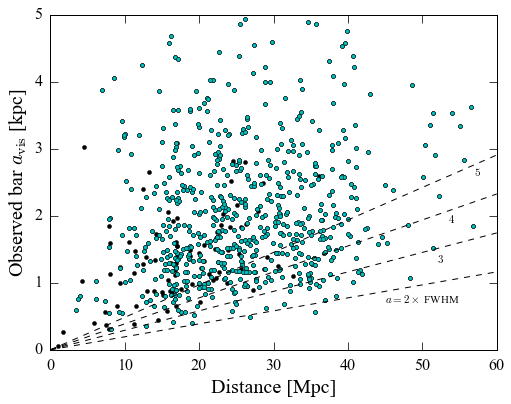

In [5]:
plt.plot(s4gdata.dist[ii_barred], s4gdata.sma_kpc[ii_barred], 'ko', ms=4)
plt.plot(s4gdata.dist[ii_barred_m9], s4gdata.sma_kpc[ii_barred_m9], 'co', ms=4)
plt.xlabel("Distance [Mpc]")
plt.ylabel(r"Observed bar $a_{\rm vis}$ [kpc]")
xx = np.arange(0,61,1)
plt.plot(xx, 2*fwhm_s4g2*pc(xx)/1e3, 'k--')
plt.plot(xx, 3*fwhm_s4g2*pc(xx)/1e3, 'k--')
plt.plot(xx, 4*fwhm_s4g2*pc(xx)/1e3, 'k--')
plt.plot(xx, 5*fwhm_s4g2*pc(xx)/1e3, 'k--')
text(45,0.7,r"$a = 2 \times$ FWHM", fontsize=11)
text(52,1.3,r"$3$", fontsize=11)
text(53.5,1.9,r"$4$", fontsize=11)
text(57,2.6,r"$5$", fontsize=11)
plt.xlim(0,60);plt.ylim(0,5)
if savePlots: plt.savefig(plotDir+"barsize-vs-distance.pdf")

## Figure 6: S4G Bar Sizes vs Stellar Mass

### Log version

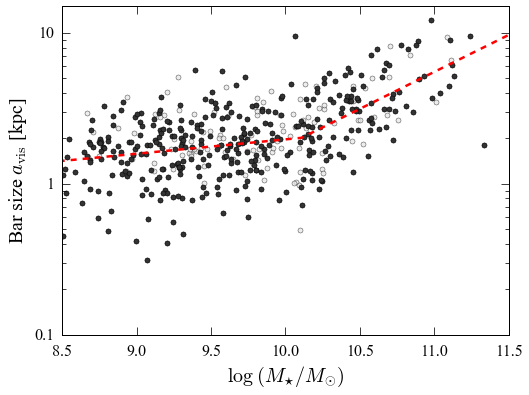

In [6]:
params_sample2 = np.array([ -0.6567681 ,   0.09511946,  10.10799995,   0.48968006])
mm = np.arange(8,12,0.01)
semilogy(s4gdata.logmstar[ii_barred_limited2], s4gdata.sma_dp_kpc2[ii_barred_limited2], 'o', mfc='0.9',ms=5, alpha=0.7)
semilogy(s4gdata.logmstar[ii_barred_limited1], s4gdata.sma_dp_kpc2[ii_barred_limited1], 'o', mfc='0.2',ms=5)
xlim(8.5,11.5);ylim(0.1,15)
plot(mm, 10**np.array(simplefunc_brokenlinear(params_sample2, mm)), 'r--', lw=2.5)
xlabel(xtmstar);ylabel(ytbarsize_kpc)
pu.MakeNiceLogAxes(whichAxis="y")
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"barsize-vs-mass-with-fit_samples12.pdf")

### Linear version

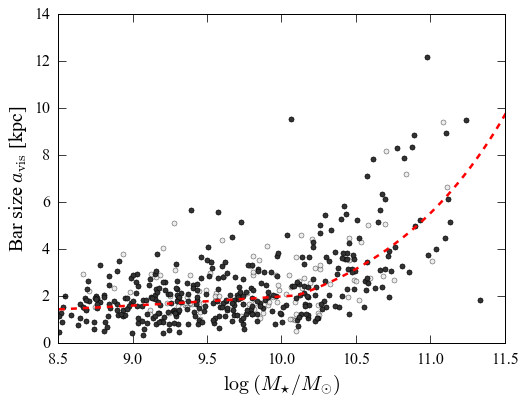

In [7]:
plot(s4gdata.logmstar[ii_barred_limited2], s4gdata.sma_dp_kpc2[ii_barred_limited2], 'o', mfc='0.9',ms=5, alpha=0.7)
plot(s4gdata.logmstar[ii_barred_limited1], s4gdata.sma_dp_kpc2[ii_barred_limited1], 'o', mfc='0.2',ms=5)
xlim(8.5,11.5);ylim(0,14)
plot(mm, 10**np.array(simplefunc_brokenlinear(params_sample2, mm)), 'r--', lw=2.5)
xlabel(xtmstar);ylabel(ytbarsize_kpc)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
plt.savefig(plotDir+"barsize-vs-mass-with-fit_samples12_linear.pdf")

## S4G Observed Bar Sizes vs Stellar Mass, Color, Gas Mass Fraction with FWHM

**Note:** In the paper, these three figures are stacked vertically to create a single composite figure (via an Adobe Illustrator file not included here).

### Figure 7 (top): Observed Bar Sizes vs Stellar Mass, with FWHM

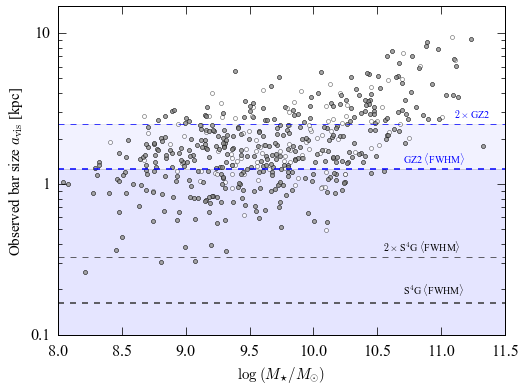

In [8]:
semilogy(s4gdata.logmstar[ii_barred_limited2], s4gdata.sma_kpc[ii_barred_limited2], 'o', color='1',ms=4, alpha=0.7)
semilogy(s4gdata.logmstar[ii_barred_limited1], s4gdata.sma_kpc[ii_barred_limited1], 'o', color='0.5',ms=4, alpha=0.7)
xlim(8,11.5);ylim(0.1,15)
ax = gca()
ax.add_patch(Rectangle((8,0.1), 3.5, fwhm_kpc_gz2 - 0.1, facecolor='b', alpha=0.1))
ax.add_patch(Rectangle((8,fwhm_kpc_gz2), 3.5, fwhm_kpc_gz2, facecolor='b', alpha=0.05))
pu.MakeNiceLogAxes(whichAxis="y")

axhline(fwhm_kpc_s4g2, ls='--', lw=1.5, color='0.2')
axhline(2*fwhm_kpc_s4g2, ls='--', lw=0.75, color='0.2')
axhline(fwhm_kpc_gz2, ls='--', lw=1.5, color='b')
axhline(2*fwhm_kpc_gz2, ls='--', lw=0.75, color='b')

text(10.7,1.15*fwhm_kpc_s4g2, s4g_fwhm_txt, fontsize=10)
text(10.55,1.11*2*fwhm_kpc_s4g2, r"$2 \times$" + s4g_fwhm_txt, fontsize=10)
text(10.7,1.1*fwhm_kpc_gz2, r"GZ2 $\langle$FWHM$\rangle$", color='b',fontsize=10)
text(11.1,1.1*2*fwhm_kpc_gz2, r"$2 \times$GZ2", color='b',fontsize=10)
xlabel(xtmstar,fontsize=15);ylabel(ytbarsize_kpc_obs,fontsize=15)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"barsize-vs-mass-with-fwhm.pdf")

### Figure 7 (middle): Observed Bar Sizes vs Galaxy Color, with FWHM

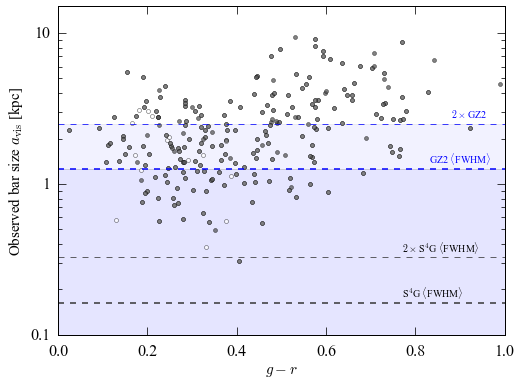

In [9]:
semilogy(s4gdata.gmr_tc[ii_barred_limited1_m8_5], s4gdata.sma_kpc[ii_barred_limited1_m8_5], 'o', color='1',ms=4, alpha=0.7)
semilogy(s4gdata.gmr_tc[ii_barred_limited2_m9], s4gdata.sma_kpc[ii_barred_limited2_m9], 'o', color='0.3',ms=4, alpha=0.7)
xlim(0,1);ylim(0.1,15)
ax = gca()
ax.add_patch(Rectangle((0,0.1), 1, fwhm_kpc_gz2 - 0.1, facecolor='b', alpha=0.1))
ax.add_patch(Rectangle((0,fwhm_kpc_gz2), 1, fwhm_kpc_gz2, facecolor='b', alpha=0.05))
pu.MakeNiceLogAxes(whichAxis="y")
plt.xlabel(xtgmr,fontsize=15)
ylabel(ytbarsize_kpc_obs,fontsize=15)

axhline(fwhm_kpc_s4g2, ls='--', lw=1.5, color='0.2')
axhline(2*fwhm_kpc_s4g2, ls='--', lw=0.75, color='0.2')
axhline(fwhm_kpc_gz2, ls='--', lw=1.5, color='b')
axhline(2*fwhm_kpc_gz2, ls='--', lw=0.75, color='b')

text(0.77,1.1*fwhm_kpc_s4g2, s4g_fwhm_txt, fontsize=10)
text(0.77,1.1*2*fwhm_kpc_s4g2, r"$2 \times$" + s4g_fwhm_txt, fontsize=10)
text(0.83,1.1*fwhm_kpc_gz2, r"GZ2 $\langle$FWHM$\rangle$", color='b',fontsize=10)
text(0.88,1.1*2*fwhm_kpc_gz2, r"$2 \times$GZ2", color='b',fontsize=10)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"barsize-vs-gmr-with-fwhm.pdf")

### Figure 7 (bottom): Observed Bar Sizes vs Gas Mass Ratio, with FWHM

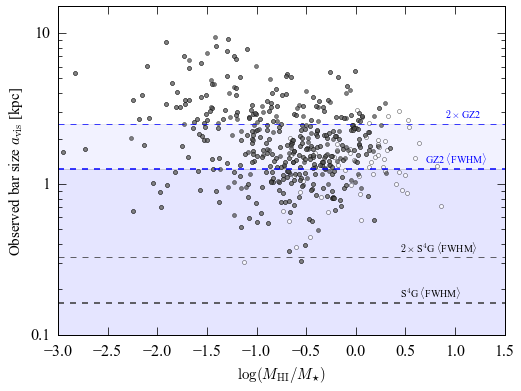

In [10]:
semilogy(s4gdata.logfgas[ii_barred_limited1_m8_5], s4gdata.sma_kpc[ii_barred_limited1_m8_5], 'o', color='1',ms=4, alpha=0.7)
semilogy(s4gdata.logfgas[ii_barred_limited2_m9], s4gdata.sma_kpc[ii_barred_limited2_m9], 'o', color='0.3',ms=4, alpha=0.7)
xlim(-3,1.5);ylim(0.1,15)
ax = gca()
ax.add_patch(Rectangle((-3,0.1), 4.5, fwhm_kpc_gz2 - 0.1, facecolor='b', alpha=0.1))
ax.add_patch(Rectangle((-3,fwhm_kpc_gz2), 4.5, fwhm_kpc_gz2, facecolor='b', alpha=0.05))
pu.MakeNiceLogAxes(whichAxis="y")
plt.xlabel(r"$\log (M_{\rm HI} / M_{\star})$", fontsize=15)
ylabel(ytbarsize_kpc_obs,fontsize=15)

axhline(fwhm_kpc_s4g2, ls='--', lw=1.5, color='0.2')
axhline(2*fwhm_kpc_s4g2, ls='--', lw=0.75, color='0.2')
axhline(fwhm_kpc_gz2, ls='--', lw=1.5, color='b')
axhline(2*fwhm_kpc_gz2, ls='--', lw=0.75, color='b')
text(0.45,1.1*fwhm_kpc_s4g2, s4g_fwhm_txt, fontsize=10)
text(0.45,1.1*2*fwhm_kpc_s4g2, r"$2 \times$" + s4g_fwhm_txt, fontsize=10)
text(0.7,1.1*fwhm_kpc_gz2, r"GZ2 $\langle$FWHM$\rangle$", color='b',fontsize=10)
text(0.9,1.1*2*fwhm_kpc_gz2, r"$2 \times$GZ2", color='b',fontsize=10)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"barsize-vs-fgas-with-fwhm.pdf")

## Figure 8: Observed Bar Sizes: GZ2 (Hoyle+2011) vs S4G

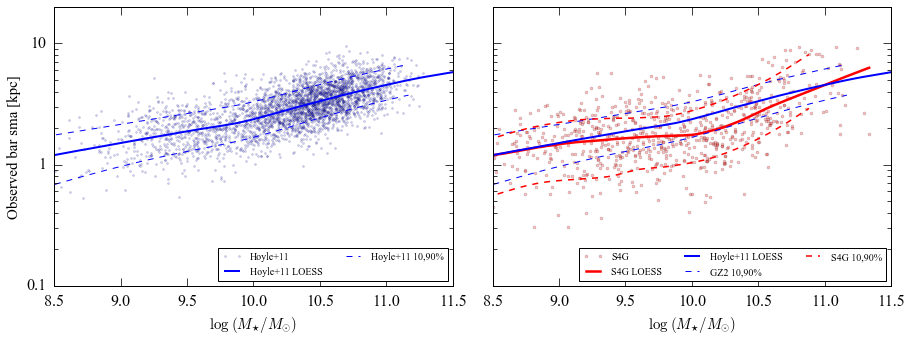

In [11]:
# get Hoyle+2011 Galaxy Zoo 2 data
ff = "./data/external/GalaxyZoo2_barlengths_alldata.txt"
h11table = du.ReadCompositeTable(ff, columnRow=0, dataFrame=True)

# get LOESS fits
h11xx, h11yy = GetSortedLoess1D(h11table.logMstar, np.log10(h11table.sma_kpc))
h11yy = 10**h11yy
s4gxx, s4gyy = GetSortedLoess1D(s4gdata.logmstar[ii_barred], np.log10(s4gdata.sma_kpc[ii_barred]))
s4gyy = 10**s4gyy

# get precomputed 10% and 90% limits for Hoyle+2011 and S4G bar sizes as fn. of log stellar mass
# (see the R notebook s4gbars_R_quantile-loess.ipynb for how these are calculated)
h11x10,h11y10 = s4gutils.Read2ColumnProfile('./data/hoyle+11_gz2_barsizes_10percentile.txt')
h11x90,h11y90 = s4gutils.Read2ColumnProfile('./data/hoyle+11_gz2_barsizes_90percentile.txt')
s4gx10,s4gy10 = s4gutils.Read2ColumnProfile('./data/s4g_barsizes_10percentile.txt')
s4gx90,s4gy90 = s4gutils.Read2ColumnProfile('./data/s4g_barsizes_90percentile.txt')


f,(ax1,ax2) = subplots(1,2, figsize=(15,5), sharey=True)

ax1.semilogy(h11table.logMstar, h11table.sma_kpc, 'o', ms=2, color='b', alpha=0.2, label="Hoyle+11")
ax1.set_xlim(8.5,11.5);ax1.set_ylim(0.1,20)
ax1.set_xlabel(xtmstar, fontsize=15)
ax1.set_ylabel(r"Observed bar sma [kpc]", fontsize=15)
ax1.plot(h11xx, h11yy, 'b', lw=2,label='Hoyle+11 LOESS')
ax1.plot(h11x10, 10**h11y10, 'b--', label="Hoyle+11 10,90%")
ax1.plot(h11x90, 10**h11y90, 'b--')
ax1.legend(loc='lower right', ncol=2, fontsize=10)
pu.MakeNiceLogAxes(whichAxis="y", axisObj=ax1)

ax2.semilogy(s4gdata.logmstar[ii_barred], s4gdata.sma_kpc[ii_barred], 'ro', ms=3, alpha=0.25, label='S4G')
ax2.set_xlim(8.5,11.5);ax2.set_ylim(0.1,20)
ax2.set_xlabel(xtmstar, fontsize=15)
ax2.plot(s4gxx, s4gyy, 'r', lw=2.5, label='S4G LOESS')
ax2.plot(h11xx, h11yy, 'b', lw=2, label='Hoyle+11 LOESS')
ax2.plot(h11x10, 10**h11y10, 'b--', label="GZ2 10,90%")
ax2.plot(h11x90, 10**h11y90, 'b--')
ax2.plot(s4gx10, 10**s4gy10, 'r--', lw=1.5, label="S4G 10,90%")
ax2.plot(s4gx90, 10**s4gy90, 'r--', lw=1.5)
ax2.legend(loc='lower right', ncol=3, fontsize=10)
pu.MakeNiceLogAxes(whichAxis="y", axisObj=ax1)

subplots_adjust(wspace=0.1)
if savePlots: savefig(plotDir+"barsizes_H11-vs-S4G.pdf")

## Figure 9: S4G Relative Bar Sizes

Intrinsic (deprojected) bar semi-major axis divided by optical radius $R_{25}$, as a function of stellar mass, with LOESS fit.

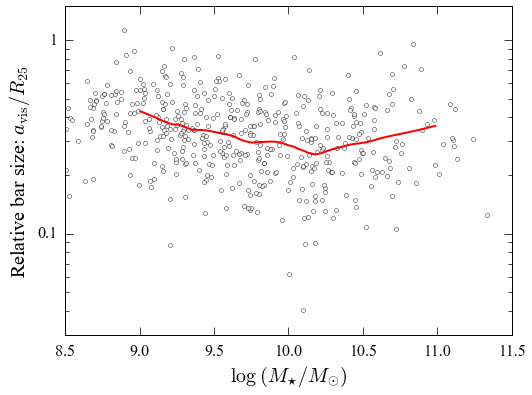

In [12]:
barsize_r25 = s4gdata.sma_dp_kpc2 / s4gdata.R25_kpc

s4gxx, s4gyy = GetSortedLoess1D(s4gdata.logmstar[ii_barred_limited2_m9to11], np.log10(barsize_r25[ii_barred_limited2_m9to11]), frac=0.3)
s4gyy = 10**s4gyy


semilogy(s4gdata.logmstar[ii_barred_limited2], barsize_r25[ii_barred_limited2], 'o', color='1',mew=0.6, ms=4, alpha=0.7)
plot(s4gxx, s4gyy, 'r-', lw=2)
xlim(8.5,11.5)
ylim(0.03,1.5)
xlabel(xtmstar)
ylabel(r"Relative bar size: $a_{\rm vis} / R_{25}$")
pu.MakeNiceLogAxes(whichAxis="y")
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)

if savePlots: savefig(plotDir+"barsize-R25_vs_logmstar-with-loess.pdf")

## Figure 11: S4G Observed Bar Sizes vs Stellar Mass with High-Redshift FWHM

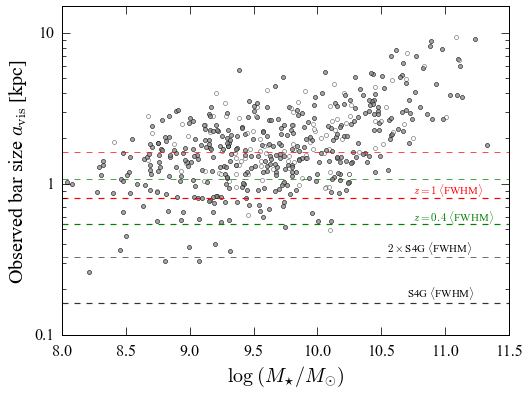

In [13]:
fwhm_kpc_hst1 = 0.54
fwhm_kpc_hst2 = 0.81

semilogy(s4gdata.logmstar[ii_barred_limited2], s4gdata.sma_kpc[ii_barred_limited2], 'o', color='1',ms=4, alpha=0.7)
semilogy(s4gdata.logmstar[ii_barred_limited1], s4gdata.sma_kpc[ii_barred_limited1], 'o', color='0.5',ms=4, alpha=0.7)
xlim(8,11.5);ylim(0.1,15)
pu.MakeNiceLogAxes(whichAxis="y")
axhline(fwhm_kpc_s4g2, ls='--', lw=1.2, color='0.2')
axhline(2*fwhm_kpc_s4g2, ls='--', lw=0.7, color='0.2')
axhline(fwhm_kpc_hst1, ls='--', lw=1.2, color='g')
axhline(2*fwhm_kpc_hst1, ls='--', lw=0.7, color='g')
axhline(fwhm_kpc_hst2, ls='--', lw=1.2, color='r')
axhline(2*fwhm_kpc_hst2, ls='--', lw=0.7, color='r')
text(10.7,1.1*fwhm_kpc_s4g2, r"S4G $\langle$FWHM$\rangle$", fontsize=11)
text(10.55,1.1*2*fwhm_kpc_s4g2, r"$2 \times$S4G $\langle$FWHM$\rangle$", fontsize=11)
text(10.75,1.06*fwhm_kpc_hst1, r"$z = 0.4 \: \langle$FWHM$\rangle$", color='g',fontsize=11)
text(10.75,1.06*fwhm_kpc_hst2, r"$z = 1 \: \langle$FWHM$\rangle$", color='r',fontsize=11)
xlabel(xtmstar);ylabel(ytbarsize_kpc_obs)
# push bottom of plot upwards so that x-axis label isn't clipped in PDF output
plt.subplots_adjust(bottom=0.14)
if savePlots: plt.savefig(plotDir+"barsize-vs-mass-with-high-z-fwhm.pdf")